# Variational Autoencoders

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/borchero/pyblaze/blob/master/examples/vae.ipynb)
[![Download Jupyter Notebbok](https://img.shields.io/badge/Github-Download-brightgreen)](https://github.com/borchero/pyblaze/blob/master/examples/vae.ipynb)

In this tutorial, we want to use PyBlaze to train a variational autoencoder (VAE). More precisely, we want to generate handwritten digits as obtained from the MNIST dataset.

Later on, we will repeat the same tutorial and train a Wasserstein GAN instead of a VAE.

**_Note: This tutorial currently lacks both explanation and any theory. It will be added in the future._**

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as D
import torchvision
import torchvision.transforms as transforms
import pyblaze.nn as xnn
import pyblaze.nn.functional as X
import matplotlib.pyplot as plt

%reload_ext autoreload
%autoreload 2

plt.style.use('seaborn-notebook')
plt.rcParams['figure.dpi'] = 150

## Loading the Data

At first, we want to load the data. Again, `torchvision` can make our life easier:

In [2]:
train_val_dataset = torchvision.datasets.MNIST(
    root="~/Downloads/", train=True, download=True, transform=transforms.ToTensor()
)
test_dataset = torchvision.datasets.MNIST(
    root="~/Downloads/", train=False, download=True, transform=transforms.ToTensor()
)

As we did before, we can also easily initialize the data loaders:

In [3]:
train_dataset, val_dataset = train_val_dataset.random_split(0.8, 0.2)
train_loader = train_dataset.loader(batch_size=256, num_workers=4, shuffle=True)
val_loader = val_dataset.loader(batch_size=2048)
test_loader = test_dataset.loader(batch_size=2048)

Before we continue to set up our model, we first have a look at a few randomly sampled images from our training data:

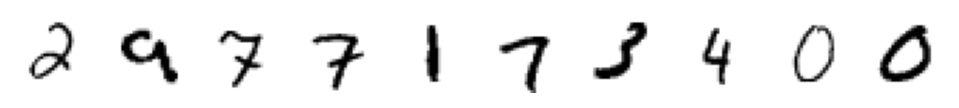

In [4]:
plt.figure()

images = [train_dataset[i] for i in np.random.choice(len(train_dataset), 10)]
for i, (image, _) in enumerate(images):
    plt.subplot(1, 10, i+1)
    plt.imshow(image[0], cmap='binary')
    plt.axis('off')

plt.show()

## Defining the Model

After we had a look at the data, we can define our model. We use convolutional layers in the encoder and scale the hidden representation up in the end.

In [5]:
class Encoder(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3),
            nn.ReLU(),
            nn.Conv2d(32, 64, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 64, 5),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc_mu = nn.Linear(576, 16)
        self.fc_logvar = nn.Linear(576, 16)
        
    def forward(self, x):
        z = self.conv(x)
        z = z.view(z.size(0), -1)
        return self.fc_mu(z), self.fc_logvar(z)
    

class Decoder(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(16, 2048)
        self.conv = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 5, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 6)
        )
        
    def forward(self, x):
        z = self.fc(x)
        z = z.view(-1, 128, 4, 4)
        return self.conv(z)


class VAE(nn.Module):

    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        mu, logvar = self.encoder(x)
        std = (0.5 * logvar).exp()
        eps = torch.randn_like(std)
        z = mu + eps * std
        return self.decoder(z), mu, logvar

Having defined the model, we can initialize it. Let's also see how big it is:

In [6]:
model = VAE()

print(f'Total parameters:   {sum(p.numel() for p in model.parameters()):6,}')
print(f'Encoder parameters: {sum(p.numel() for p in model.encoder.parameters()):6,}')
print(f'Decoder parameters: {sum(p.numel() for p in model.decoder.parameters()):6,}')

Total parameters:   464,577
Encoder parameters: 172,512
Decoder parameters: 292,065


## Training the Model

In [7]:
optimizer = optim.Adam(model.parameters())
loss = xnn.VAELoss(nn.BCEWithLogitsLoss(reduction='none'))
engine = xnn.AutoencoderEngine(model, expects_data_target=True)

In [8]:
history = engine.train(
    train_loader,
    val_data=val_loader,
    epochs=50,
    eval_every=5,
    optimizer=optimizer,
    loss=loss,
    callbacks=[
        xnn.BatchProgressLogger()
    ]
)

Epoch 1/50:
 [Elapsed 0:00:05 | 33.81 it/s] loss: 224.27307, val_loss: 159.77618                 
Epoch 2/50:
 [Elapsed 0:00:03 | 48.45 it/s] loss: 136.16475                                      
Epoch 3/50:
 [Elapsed 0:00:03 | 47.73 it/s] loss: 118.60185                                      
Epoch 4/50:
 [Elapsed 0:00:03 | 47.37 it/s] loss: 113.22937                                      
Epoch 5/50:
 [Elapsed 0:00:03 | 48.84 it/s] loss: 110.84675                                      
Epoch 6/50:
 [Elapsed 0:00:05 | 33.62 it/s] loss: 109.05308, val_loss: 108.66338                 
Epoch 7/50:
 [Elapsed 0:00:03 | 48.16 it/s] loss: 107.91442                                      
Epoch 8/50:
 [Elapsed 0:00:03 | 48.23 it/s] loss: 106.88257                                      
Epoch 9/50:
 [Elapsed 0:00:03 | 48.17 it/s] loss: 106.14308                                      
Epoch 10/50:
 [Elapsed 0:00:04 | 46.60 it/s] loss: 105.65662                                      
Epoch 11/50:
 [Elap

## Inspecting the Model

### Reconstructing Images

In [9]:
reconstructed = engine.predict(
    test_loader,
    reconstruct=True
)

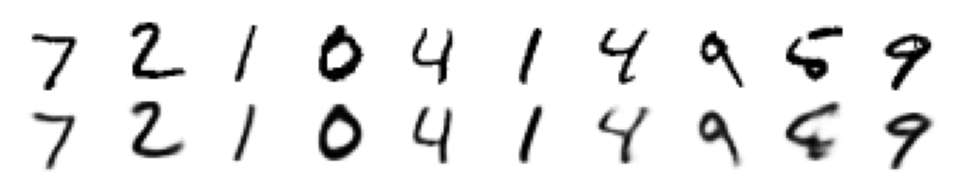

In [10]:
plt.figure(dpi=150)

im = next(iter(test_loader))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(np.concatenate([
        im[0][i][0].numpy(),
        reconstructed[0][i].sigmoid().numpy().reshape(28, 28)
    ]), cmap='binary')
    plt.axis('off')

plt.show()

### Generating Images

In [11]:
dim = 16
distribution = D.Normal(torch.zeros(dim), torch.ones(dim))
dist_data = xnn.NoiseDataset(distribution)

In [12]:
generated = engine.predict(
    dist_data.loader(batch_size=10),
    iterations=1,
    reconstruct=False
)

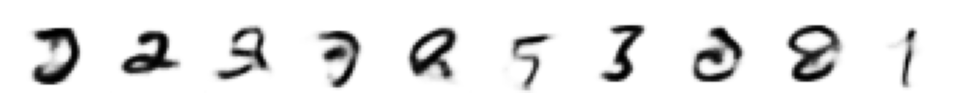

In [13]:
plt.figure()

for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(generated[i].sigmoid().numpy().reshape(28, 28), cmap='binary')
    plt.axis('off')

plt.show()